<h1> Проект e-commerce <h1>

<h3> ИМПОРТ БИБЛИОТЕК <h3>

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re
from io import BytesIO
import requests
import numpy as np
import os
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime

<h3> ЗАГРУЗКА ДАННЫХ <h3>

In [12]:
# Для упрощения работы проверяющим файлы были загружены на гугл диск, чтобы была возможно считать их без скачивания))

url_1 = 'https://drive.google.com/file/d/1WnNluKlP4JSYOCrKbYtajkiXcwQL6Amf/view?usp=sharing'
path_1 = 'https://drive.google.com/uc?export=download&id=' + url_1.split('/')[-2]
olist_customers_dataset = pd.read_csv(path_1)

url_2 = 'https://drive.google.com/file/d/1eC8f2xpXhw1kkqP_SbAF9DYoY5LHPQcE/view?usp=sharing'
path_2 = 'https://drive.google.com/uc?export=download&id=' + url_2.split('/')[-2]
olist_orders_dataset = pd.read_csv(path_2)

url_3 = 'https://drive.google.com/file/d/1XN2P6EmBZJeGIEuSSCRhA1Ke3RP__vjl/view?usp=sharing'
path_3 = 'https://drive.google.com/uc?export=download&id=' + url_3.split('/')[-2]
olist_order_items_dataset = pd.read_csv(path_3)

## <blockquote> Покупкой считается оплаченный заказ, то есть имеющий статус processing, shipped или delivered, т.к. в таких случаях оплата совершена, и в первом случае готовиться к отправке, во втором - отправился, а в третьем - заказ уже доставлен.  В заказе может содержаться несколько позиций одновременно, если человек оплатил их в один и тот же момент. <br><br> Во всех иных случаях (статусы created, approved, invoiced, unavailable, canceled) заказ либо ещё не оплачен (из имеющихся данных  считаем, что оплата происходит до сборки заказа), либо по нему нет информации (статус unavailable), либо отмненен, что аннулирует факт покупки, ведь деньги должны были вернуться к пользователю.

<h2> ЗАДАНИЕ №1 <h2>

<h4>Сколько у нас пользователей, которые совершили покупку только один раз?<h4>

In [13]:
# Кол-во заказов, которые совершил пользователь, считалось по тому, сколько заказов можно считать покупкой (подходят под 
# заданное нами условие).

task_1_1 = olist_customers_dataset[['customer_id', 'customer_unique_id']]
# Переменная task_1_1 - изменённый датасет olist_customers_dataset, где остались только необходимые для выполнения задания 
# столбцы.
modified_dataframe_1 = olist_orders_dataset.merge(task_1_1, how='inner', on='customer_id')
# Переменная modified_dataset_1 - изменённый датасет olist_customers_dataset olist_orders_dataset. В результате изменений была 
# добавлена колонка customer_unique_id для вычисления числа пользователей, которые так или иначе совершили заказ.

modified_dataframe_1.order_purchase_timestamp = pd.to_datetime(modified_dataframe_1.order_purchase_timestamp,\
                                                               format='%Y-%m-%d %H:%M:%S')
modified_dataframe_1.order_approved_at = pd.to_datetime(modified_dataframe_1.order_approved_at, format='%Y-%m-%d %H:%M:%S')
modified_dataframe_1.order_delivered_carrier_date = pd.to_datetime(modified_dataframe_1.order_delivered_carrier_date,\
                                                               format='%Y-%m-%d %H:%M:%S')
modified_dataframe_1.order_delivered_customer_date = pd.to_datetime(modified_dataframe_1.order_delivered_customer_date,\
                                                               format='%Y-%m-%d %H:%M:%S')
modified_dataframe_1.order_estimated_delivery_date = pd.to_datetime(modified_dataframe_1.order_estimated_delivery_date,\
                                                               format='%Y-%m-%d %H:%M:%S')
# Для дальнейшего удобства привели все даты к нужному формату.

purchased = ['processing', 'shipped', 'delivered']
# Переменная purchased - список статусов заказа, которые имеют купленные товары.

task_1 = (modified_dataframe_1.query("order_status in @purchased").groupby('customer_unique_id', as_index=False).\
      agg({'order_status': 'count'}).order_status == 1).value_counts()[1]
# Переменная task_1 - необходимое нам число пользователей, которые совершили ровно 1 покупку.
# Сгруппировали переменные по колонке с уникальными идентификаторами пользователями, посчитали сколько заказов совершил каждый
# пользователь и вывели число тех, которые совершили только 1 покупку.

task_1

91814

<h2> ЗАДАНИЕ №2 <h2>

<h4>Сколько заказов в месяц в среднем не доставляется по разным причинам?<h4>

In [14]:
modified_dataframe_1['month_name'] = modified_dataframe_1.order_purchase_timestamp.dt.month_name()
# Для выполнения этого задания в датафрейме modified_dataset_1 создали новую колонку, где отображается месяц, когда был создан 
# заказ.

task_2 = modified_dataframe_1.\
    query("order_status == 'canceled' and order_delivered_customer_date != order_delivered_customer_date").\
    groupby('month_name', as_index=False).agg({'order_status': 'count'}).order_status.mean()
# К сожалению, кол-во данных в датафрейме не дает нам всей картины, и узнать был ли заказ не доставлен, мы можем только по 
# одному статусу, а именно canceled (статус unavailable нельзя рассматривать, т.к., мы просто не знаем по каким причинам нам не 
# доступен статус заказа, это может быть как потеря данных, так и какая-то причина удаления статуса заказа, а так же по тому, 
# есть ли у заказа время доставки.
# Далее, просто сгруппировали данные, посчитали кол-во недоставленных заказов по единственной известной нам причине за каждый 
# месяц и нашли среднее этих значений (нашли переменную task2).

task_2

51.583333333333336

<h2> ЗАДАНИЕ №3 <h2>

<h4>По каждому товару определить, в какой день недели товар чаще всего покупается.<h4>

In [15]:
task_3_1 = olist_order_items_dataset[['order_id', 'product_id']]
# Переменная task_3_1 - изменённый датасет olist_order_items_dataset, где остались только необходимые для выполнения задания 
# столбцы.

modified_dataframe_2 = modified_dataframe_1.merge(task_3_1, how='inner', on='order_id')
# Переменная modified_dataset_1 - измененный датафрейм modified_dataset_1. В результате изменений была добавлена колонка 
# product_id для того, чтобы узнать какой товар в какой день недели чаще всего покупают.

modified_dataframe_2['weekday_name'] = modified_dataframe_2.order_purchase_timestamp.dt.day_name()
# Для выполнения этого задания в датафрейме modified_dataset_1 создали новую колонку, где отображается день недели, 
# когда был создан заказ.

modified_dataframe_2['weekday'] = modified_dataframe_2.weekday_name
# Также создали точно такую же колонку для возможности посчитать сколько раз товар купили в тот или иной день недели.

task_3 = modified_dataframe_2.query("order_status in @purchased").groupby(['product_id', 'weekday_name'], as_index=False).\
     agg({'weekday': 'count'}).sort_values('weekday', ascending = False).drop_duplicates(subset=['product_id']).\
     reset_index(drop=True).drop(columns='weekday')
# Переменная task3 - необходимый нам датафрейм, который показывает когда товар покупают (то есть произошел акт покупки, который
# был оговорен в самом начале) чаще всего.
# Для выполнения задания сгруппировали датафрейм modified_dataset_2 так, чтобы остались только колонки product_id, weekday_name 
# и weekday, в последней из которых показывается, сколько раз товар покупали в какой день недели. 
# Далее осортировали значения по убыванию, чтобы дни, в которые покупают больше были в начале датафрейма, удалили дубликаты из
# датафрейма, а также колонку, в которой показывается конкретное число покупок товара в этот день, т.к. в итоге нам нужен только
# день, когда купили товар.

modified_dataframe_2 = modified_dataframe_2.drop(columns='weekday')
# Данная колонка-дубликат нам не нужна, так что удалим её и из modified_dataframe_2))

task_3

,product_id,weekday_name
0,422879e10f46682990de24d770e7f83d,Wednesday
1,99a4788cb24856965c36a24e339b6058,Monday
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday
3,53b36df67ebb7c41585e8d54d6772e08,Tuesday
4,389d119b48cf3043d311335e499d9c6b,Thursday
...,...,...
32609,6435be64ad92f52631170f9a92718a99,Sunday
32610,64367bed3ed96fd9381676fbe33b6443,Sunday
32611,643a4049ae3e6df63858575f28cd7b21,Friday
32612,643a66b1dc5dad3de6cb5a41549e72f1,Sunday


<h2> ЗАДАНИЕ №4 <h2>

<h4>Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?<h4>

In [16]:
# Количество покупок – количество заказов, которые мы считаем покупкой.

modified_dataframe_1['days_in_month'] = modified_dataframe_1.order_purchase_timestamp.dt.daysinmonth
# Для выполнения задания в датафрейм modified_dataframe_1 (мы используем именно modified_dataframe_1, т.к. в нем нет лишних 
# строк с описанием позиций в чеке покупателя и сохраняется определение покупки, которое было дано в самом начале) добавим 
# колонку с количеством дней в месяце, когда был создан заказ.

task_4_1 = modified_dataframe_1.query("order_status in @purchased").\
    groupby(['customer_unique_id', 'month_name', 'days_in_month'], as_index=False).agg({'order_status': 'count'})
# Переменная task_4_1 – датафрейм, где находятся уникальные id пользователя, месяц, когда был совершен заказ, кол-во дней в 
# этом месяце и сколько пользователь совершил заказов за этот месяц.

task_4_1['week_mean'] = task_4_1.order_status/(task_4_1.days_in_month/7)
# Далее в датафрейм task_4_1 добавим колонку week_mean с кол-вом заказов, совершённых в среднем в неделю за каждый месяц. 
# Значения считали, как кол-во покупок за месяц, делённое на кол-во недель в месяце (кол-во дней в месяце делённое на 7 (кол-во 
# дней в неделю)).

task_4 = task_4_1.drop(columns=['days_in_month', 'order_status']).sort_values('customer_unique_id').reset_index(drop=True)
# Переменная task_4 – необходимый нам датафрейм, для его получения мы просто удалили лишние колонки и отсортировали значения, 
# чтобы все значения покупок в среднем в неделю по месяцам для одного пользователя шли по порядку.

task_4

,customer_unique_id,month_name,week_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,May,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,0.225806
2,0000f46a3911fa3c0805444483337064,March,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,0.233333
...,...,...,...
96512,fffcf5a5ff07b0908bd4e2dbc735a684,June,0.233333
96513,fffea47cd6d3cc0a88bd621562a9d061,December,0.225806
96514,ffff371b4d645b6ecea244b27531430a,February,0.250000
96515,ffff5962728ec6157033ef9805bacc48,May,0.225806


<h2> ЗАДАНИЕ №5 <h2>

<h4>Провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на третий месяц.<h4>

In [17]:
modified_dataframe_1['year'] = modified_dataframe_1.order_purchase_timestamp.dt.year
modified_dataframe_1['year_month'] = pd.to_datetime(modified_dataframe_1.year.astype(str) + '-' \
                                                    + modified_dataframe_1.order_purchase_timestamp.dt.month.astype(str))
# Для выполнения данного задания нам понадобится два новых столбца в датафрейме modified_dataframe_1.
# Они показывают нам в каком году и в каком месяце в этом году была совершена покупка.

task_5_1 = modified_dataframe_1.\
    query("order_status in @purchased")[['customer_unique_id', 'year_month', 'year', 'days_in_month']]
# Переменная task_5_1 – изменённый датафрейм modified_dataframe_1, где остались только необходимые колонки, и все пользователи 
# совершили главное действие – совершили покупку.

task_5_2 = task_5_1.groupby('customer_unique_id', as_index=False).agg({'year_month':  'min', 'year':  'min'})
# Переменная task_5_2 – датафрейм, где показана дата первой покупки пользователя, а конкретно – год-месяц и год.

task_5_3 = task_5_1.merge(task_5_2, how='inner', on='customer_unique_id')
# Переменная task_5_3 – датафрейм task_5_1, куда мы добавили даты первых покупок пользователей.

task_5_3 = task_5_3.rename(columns={'year_month_x': 'date_of_purchase', 'year_month_y': 'cohorts', \
                                    'year_y': 'first_purchase_year', 'year_x': 'year_of_purchase'})
# Для удобства переименовали колонки.

task_5_3 = task_5_3.query("first_purchase_year == 2017 and year_of_purchase == 2017")
# В задании нам предоставили временной промежуток проведения когортного анализа – с января по декабрь, и под поставленное 
# требование подходит только 2017-ый год, т.к. данные за 2016-ый и 2018-ый года неполные.

task_5_3['months'] = ((pd.to_timedelta(task_5_3.date_of_purchase - task_5_3.cohorts).dt.total_seconds())\
                                          /(24*60*60*task_5_3.days_in_month)).round()
# Так же добавим колонку, показывающую сколько месяцев с момента первой покупки до какой-либо покупки пользователя.
# Т.к. разницу мы получили в днях, приведём их к месяцам, как изначально и планировали.

task_5_4 = task_5_3.groupby(['cohorts', 'months', 'days_in_month'], as_index=False).\
    agg({'customer_unique_id': 'nunique'})
# Переменная task_5_4 – датафрейм, где мы уже разделили пользователей по когортам (месяцам в 2017-ом году, когда пользователи 
# совершили первую покупку).

task_5_4.cohorts = task_5_4.cohorts.dt.to_period('M')
# Так же мы привели столбец cohorts к более удобному виду.

task_5_5 = task_5_4.pivot(index='cohorts', columns='months', values='customer_unique_id')
# Переменная task_5_5 – сводная таблица, на ней показано, сколько новых пользователей из определенной когорты возвращалось в 
# течении исследуемого промежутка времени.

task_5_5.index = task_5_5.index.to_series().astype(str)
# Теперь для красивого вывода ответа приведем индексы к другому типу данных – строкам.

for i in range (task_5_5.shape[0]):
        task_5_5.iloc[[i]] = ((task_5_5.iloc[[i]]/task_5_5.iloc[i, 0]))
# Для более правильного подсчета Retention rate посчитаем проценты возвращающихся пользователей в каждом месяце.

task_5 = (task_5_5.iloc[list(np.where(task_5_5[3.0] == task_5_5[3.0].max())[0])][3.0]).index[0]
# Переменная task_5 – необходимая для выполнения задания когорта. Она отобрана по следующим признакам: нам необходим третий 
# месяц и нужна когорта с самым высоким Retention rate.

print(task_5)

2017-05


<AxesSubplot:xlabel='months', ylabel='cohorts'>

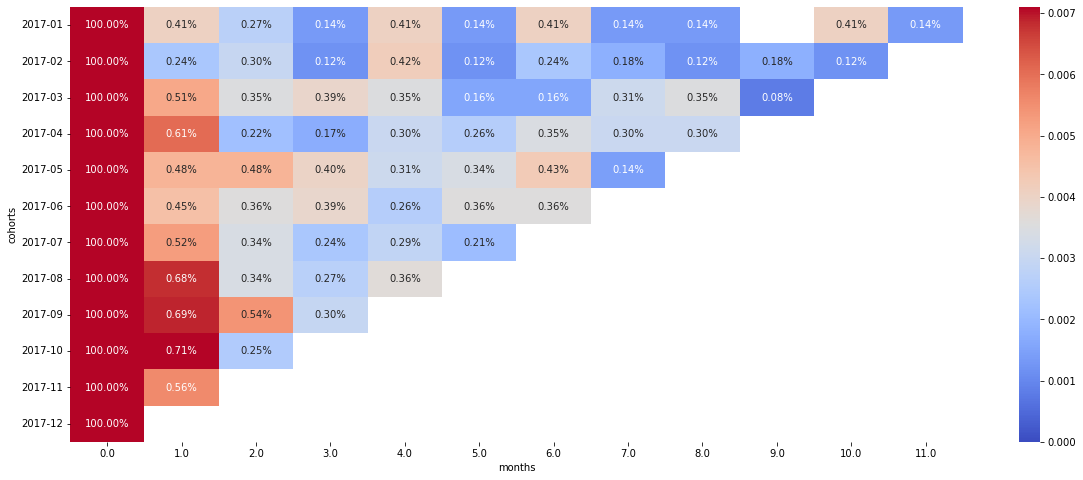

In [18]:
plt.figure(figsize=(20, 8))
sns.heatmap(task_5_5, annot=True, fmt='.2%', cmap= 'coolwarm', vmin=0, vmax=0.0071)
#Для наглядности подсчета Retention rate за исследуемый период выведем heatmap.
#Как видно, крайне малое число пользователей возвращалось после совершения первой покупки.

<h2> ЗАДАНИЕ №6 <h2>

<h4>Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию.<h4>

In [19]:
# Вот и пришло время последнего задания))

task_6_1 = modified_dataframe_1.query("order_status in @purchased")[['customer_unique_id', 'order_id']]
# Для выполнения задания нам потребуется несколько колонок из датафрейма modified_dataframe_1 (переменная task_6_1), главное 
# условие – строки этих колонок подходят под условие – пользователь совершил покупку.

task_6_2 = olist_order_items_dataset[['order_id', 'price']]
# Переменная task_6_2 – датафрейм, состоящий из двух колонок из датасета olist_order_items_dataset.

task_6_3 = task_6_1.merge(task_6_2, how='inner', on='order_id')
# Переменная task_6_3 – изменённый датафрейм task_6_1, куда мы добавили две необходимую колонку price для подсчета прибыли, 
# которую принес каждый пользователь (показатель M).

task_6_4 = task_6_3.groupby('customer_unique_id', as_index=False).agg({'price': 'sum'})
# Переменная task_6_4 – датафрейм, где показана потраченная пользователем сумма в интернет-магазине.

task_6_4.price = pd.cut(task_6_4.price, 3, labels=[1, 2, 3])
# Разделим потраченные суммы пользователями на сегменты: те, которые потратили до 4480.567 включительно (1), те, что потратили 
# от 4480.567, не включительно, до 8960.283 включительно (2), и те, что потратили от 8960.283, не включительно, до 13440.0, 
# включительно (3).

task_6_4 = task_6_4.rename(columns={'price': 'M'})
# Для удобства переименуем колонку price.

task_6_5 = modified_dataframe_1.groupby('customer_unique_id', as_index=False).\
    agg({'order_purchase_timestamp': 'max', 'order_status': 'count'})
# Переменная task_6_5 – датафрейм, где показаны последняя дата покупки пользователя и кол-во совершенных им покупок 
# (показатель F)

task_6_5 = task_6_5.rename(columns={'order_purchase_timestamp': 'date_of_last_purchase', 'order_status': 'F_1'})
# Опять же, для удобства переименовываем колонки))

task_6_6 = task_6_4.merge(task_6_5, how='inner', on='customer_unique_id')
# Объединим датафреймы task_6_4 и task_6_5 (создадим переменную task_6_6) с которым и будем работать до конца.

task_6_6['R_1'] = pd.to_datetime(datetime.datetime.now().date()) - task_6_6.date_of_last_purchase
# Создадим колонку R_1, где будет показано, сколько времени прошло с последней покупки пользователя до сегодняшней даты 
# (показатель R, назвали R_1, чтобы потом изменить местоположение для удобства).

task_6_6.R_1 = pd.cut(task_6_6.R_1, 3, labels=[1, 2, 3])
# Так же разделим полученные даты на сегменты: те, кто совершили последнюю покупки не более чем 1622 дней назад (включительно) 
# (1), те, кто совершили покупку в промежуток от 1622 дней назад (не включительно), до 1879 дней назад (включительно) (2), и 
# те, что последний раз купили в промежуток от 1879 дней назад (не включительно) до 2137 дней назад (включительно) (3).
# P.S. Ваши значения будут отличаться в зависимости от даты проверки, однако глобально они не повлияют на результат.

task_6_6.F_1 = pd.cut(task_6_6.F_1, 3, labels=[1, 2, 3])
# Теперь разделим значения в колонке F_1 (показатель F) на сегменты: те, кто совершили до 6 покупок, включительно (1), те, кто 
# совершили от 6 покупок не включительно, до 11 покупок, включительно (2), и те, что совершили от 11 покупок, не включительно, 
# до 17 покупок, включительно (3).

task_6_6.insert(1, "R", task_6_6.R_1)
task_6_6.insert(2, "F", task_6_6.F_1)
# Для удобства поставим колонки в следующем порядке: R-F-M, путем добавления колонок R и F в определенное место, путем выбора 
# индексов.

task_6 = task_6_6.drop(columns=['date_of_last_purchase', 'R_1', 'F_1'])
# Переменная task_6 – нужный для выполнения задания датафрейм. Для его создания мы просто удалили лишние колонки из датафрейма 
# task_6_6.

task_6

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,1
2,0000f46a3911fa3c0805444483337064,3,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,2,1,1
...,...,...,...,...
94680,fffcf5a5ff07b0908bd4e2dbc735a684,2,1,1
94681,fffea47cd6d3cc0a88bd621562a9d061,2,1,1
94682,ffff371b4d645b6ecea244b27531430a,3,1,1
94683,ffff5962728ec6157033ef9805bacc48,1,1,1


<h2> Выводы <h2>

## <blockquote> При выполнении первого и двух последних заданий становится понятно, что в большинстве своем пользователи совершают разовые покупки и не заинтересованы возвращаться в интернет-магазин для повторных покупок. <br> Возможно, это связано с тем, что магазин продаёт узкоспециализированные товары и не подходит массовому пользователю, т.к. каждый месяц приходят новые пользователи, но при этом они не возвращаются. Кроме того, они могут приобретать товары, которые необходимы только в разовой покупке (крупная бытовая техника, автомобили). <br> С более большим количеством данных можно было бы сделать более корректные и полные выводы.